                                                  review sentiment
33553  I really liked this Summerslam due to the look...  positive
9427   Not many television shows appeal to quite as m...  positive
199    The film quickly gets to a major chase scene w...  negative
12447  Jane Austen would definitely approve of this o...  positive
39489  Expectations were somewhat high for me when I ...  negative
sentiment
positive    5039
negative    4961
Name: count, dtype: int64


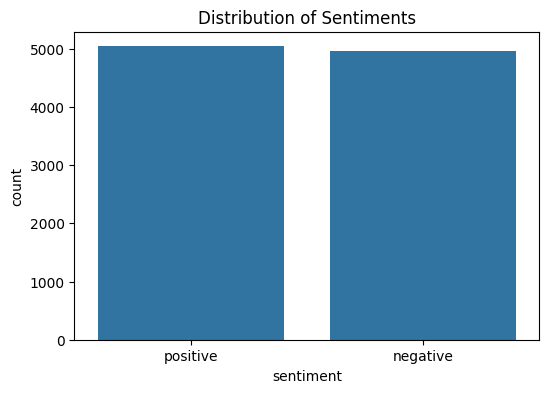

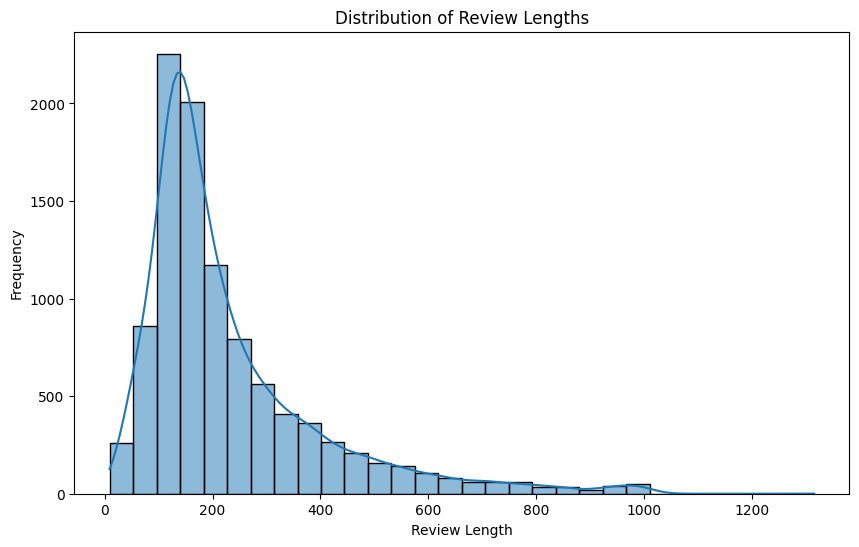

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('IMDB_Dataset.csv')

# Limit the dataset size
df = df.sample(n=10000, random_state=42)

# EDA (Exploratory Data Analysis)
print(df.head())
print(df['sentiment'].value_counts())

# Plot sentiment distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.show()

# Analyze review lengths
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=30, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

# Preprocessing
def clean_text(text):
    text = re.sub(r'<[^>]*>', ' ', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-letters
    return text.lower()

df['cleaned_review'] = df['review'].apply(clean_text)

# Encoding sentiments
le = LabelEncoder()
df['encoded_sentiment'] = le.fit_transform(df['sentiment'])

# Tokenization and padding
max_words = 20000  # Number of unique words to keep
max_length = 200  # Maximum length of each review

# Create a word index
word_index = {}
for i, review in enumerate(df['cleaned_review']):
    for word in review.split():
        if word not in word_index:
            word_index[word] = len(word_index) + 1  # Start indexing from 1

# Convert text reviews to sequences
sequences = []
for review in df['cleaned_review']:
    sequence = [word_index[word] for word in review.split() if word in word_index]
    sequences.append(sequence)

# Padding sequences to ensure consistent input shape
X = np.zeros((len(sequences), max_length), dtype=np.float32)  # Use float32
for i, seq in enumerate(sequences):
    if len(seq) > max_length:
        seq = seq[:max_length]
    X[i, :len(seq)] = seq

y = df['encoded_sentiment'].values.astype(np.float32)  # Use float32 for labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ANN Implementation




In [6]:
import numpy as np

# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

# Derivatives for backpropagation
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

# Initialize weights and biases
def initialize_parameters(input_size, hidden_layer_sizes, output_size):
    parameters = {}
    layer_sizes = [input_size] + hidden_layer_sizes + [output_size]

    for l in range(1, len(layer_sizes)):
        parameters['W' + str(l)] = np.random.randn(layer_sizes[l], layer_sizes[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_sizes[l], 1))

    return parameters

# Forward propagation
def forward_propagation(X, parameters):
    cache = {}
    A = X.T  # Transpose input to align for matrix multiplication
    L = len(parameters) // 2  # number of layers

    for l in range(1, L):
        Z = np.dot(parameters['W' + str(l)], A) + parameters['b' + str(l)]
        A = relu(Z)
        cache['Z' + str(l)] = Z
        cache['A' + str(l)] = A

    ZL = np.dot(parameters['W' + str(L)], A) + parameters['b' + str(L)]
    AL = sigmoid(ZL)
    cache['Z' + str(L)] = ZL
    cache['A' + str(L)] = AL

    return AL, cache

# Backward propagation
def backward_propagation(X, Y, cache, parameters):
    grads = {}
    m = X.shape[1]
    L = len(parameters) // 2  # number of layers

    # Output layer gradients
    dZL = cache['A' + str(L)] - Y
    grads['dW' + str(L)] = np.dot(dZL, cache['A' + str(L-1)].T) / m
    grads['db' + str(L)] = np.sum(dZL, axis=1, keepdims=True) / m

    # Backpropagate through hidden layers
    for l in reversed(range(1, L)):
        dA = np.dot(parameters['W' + str(l+1)].T, dZL)
        dZ = dA * relu_derivative(cache['Z' + str(l)])
        grads['dW' + str(l)] = np.dot(dZ, X.T if l == 1 else cache['A' + str(l-1)].T) / m
        grads['db' + str(l)] = np.sum(dZ, axis=1, keepdims=True) / m
        dZL = dZ

    return grads

# Update parameters using gradient descent
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2  # number of layers

    for l in range(1, L+1):
        parameters['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
        parameters['b' + str(l)] -= learning_rate * grads['db' + str(l)]

    return parameters

# Train the model with mini-batch gradient descent
def train(X_train, Y_train, input_size, hidden_layer_sizes, output_size, epochs, learning_rate, batch_size):
    parameters = initialize_parameters(input_size, hidden_layer_sizes, output_size)

    for epoch in range(epochs):
        # Shuffle the data
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        
        # Mini-batch gradient descent
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            X_batch = X_train[batch_indices].T  # Use transpose to align with weight dimensions
            Y_batch = Y_train[batch_indices].reshape(1, -1)

            # Forward propagation
            AL, cache = forward_propagation(X_batch, parameters)
            
            # Compute cost
            cost = binary_cross_entropy(Y_batch, AL)
            
            # Backward propagation
            grads = backward_propagation(X_batch, Y_batch, cache, parameters)
            
            # Update parameters
            parameters = update_parameters(parameters, grads, learning_rate)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Cost: {cost}")

    return parameters

# Predict function
def predict(X, parameters):
    AL, _ = forward_propagation(X.T, parameters)  # Transpose for forward propagation
    return np.round(AL.T)




In [11]:
# Example usage of the above neural network with IMDb dataset
input_size = X_train.shape[1]  # Number of input features (200 in this case after padding)
hidden_layer_sizes = [64, 32]  # Adjust hidden layer sizes
output_size = 1  # Binary output
epochs = 1000
learning_rate = 0.01
batch_size = 64  # Mini-batch size

# Convert y_train to a 2D array
y_train_reshaped = y_train.reshape(-1, 1)




In [12]:
# Train the model
parameters = train(X_train, y_train_reshaped, input_size, hidden_layer_sizes, output_size, epochs, learning_rate, batch_size)




ValueError: shapes (64,200) and (64,200) not aligned: 200 (dim 1) != 64 (dim 0)

In [9]:
# Test the model
predictions = predict(X_test, parameters)

# Calculate accuracy
accuracy = np.mean(predictions == y_test.reshape(-1, 1))
print(f"Test Accuracy: {accuracy * 100:.2f}%")


NameError: name 'parameters' is not defined